In [0]:

import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch.nn as nn
import torch

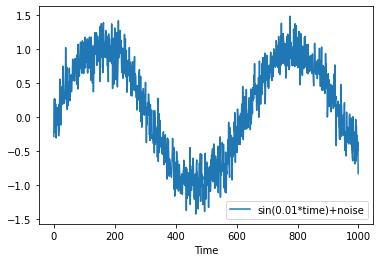

In [102]:
import torch

T = 1000
time = torch.arange(0.0, T)
X = torch.sin(0.01 * time) + 0.2 * torch.randn(T)
plt.plot(time.numpy(), X.numpy(), label="sin(0.01*time)+noise");
plt.legend();
plt.xlabel("Time");
plt.show()

In [0]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

# Hyperparameter
batch_size, train_number = 16, 600

# timestamp
tau = 4
features = torch.zeros((T-tau, tau)) # AR Model needs tau inputs: shape is (996, 4)

for i in range(tau):
    features[:, i] = X[i:(T-tau + i)]
labels = X[tau:] # shape is (996, )

# Prepare DataLoader
train_data = TensorDataset(features[:train_number, :], labels[:train_number])
test_data = TensorDataset(features[train_number:, :], labels[train_number:])

In [0]:
import torch.nn as nn

# Parameter Initialization
def init_weight(map_):
    if type(map_) == nn.Linear:
        torch.nn.init.xavier_uniform_(map_.weight)

# Vanilla MLP architecture
def MLP():
    net = nn.Sequential()
    net.add_module("Linear_1", nn.Linear(tau, 10, bias=False))
    net.add_module("ReLU", nn.ReLU())
    net.add_module("Final", nn.Linear(10, 1, bias=False))
    net.apply(init_weight)

    return net

In [105]:
# Least mean squares loss
criterion = nn.MSELoss()
optimizer = torch.optim.Adam

# textbook code
def train_net(net, data, criterion, epochs, lr_rate):
    optim = optimizer(net.parameters(), lr=lr_rate)
    data_iter = DataLoader(data, batch_size, shuffle=True)

    for epoch in range(1, epochs+1):
        running_loss = 0.0
        
        for x, y in data_iter:
            optim.zero_grad()
            output = net(x)
            loss = criterion(output, y.reshape(-1, 1))
            loss.backward()
            optim.step()
            running_loss += loss.item()
        
        print("epoch: {}, loss: {:.2f}".format(epoch, running_loss))
    
    test_loss = criterion(net(test_data[:][0]), test_data[:][1].reshape(-1,1))
    print('test loss: %f' % test_loss.mean().detach().numpy())

    return net
    
net = MLP()
net = train_net(net, train_data, criterion, 10, 0.01)

epoch: 1, loss: 4.19
epoch: 2, loss: 2.38
epoch: 3, loss: 2.26
epoch: 4, loss: 2.22
epoch: 5, loss: 2.19
epoch: 6, loss: 2.18
epoch: 7, loss: 2.28
epoch: 8, loss: 2.18
epoch: 9, loss: 2.10
epoch: 10, loss: 2.17
test loss: 0.049572


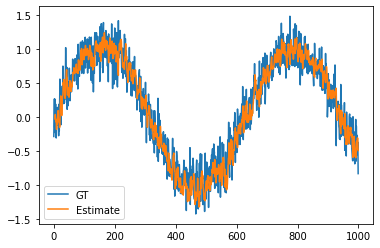

In [106]:
estimates = net(features)
plt.plot(time.numpy(), X.numpy(), label='GT');
plt.plot(time[tau:].numpy(), estimates.detach().numpy(), label='Estimate');
plt.legend();

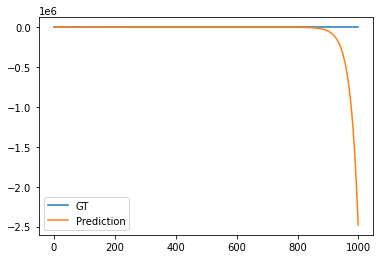

In [107]:
predictions = torch.zeros_like(estimates)
predictions[:(train_number - tau)] = estimates[:(train_number - tau)]

for i in range((train_number - tau), (T - tau)):
    predictions[i] = net(
        predictions[(i - tau):i].reshape(1, -1)
    ).reshape(1)

plt.plot(time.numpy(), X.numpy(), label='GT');
plt.plot(time[tau:].numpy(), predictions.detach().numpy(), label='Prediction');
plt.legend();

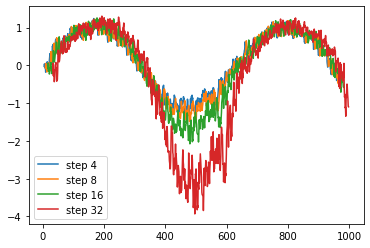

In [108]:
k = 33  # Look up to k - tau steps ahead

features = torch.zeros((T-k, k))
for i in range(tau):
    features[:, i] = X[i:T-k+i]

for i in range(tau, k):
    features[:, i] = net(features[:,(i-tau):i]).reshape((-1))

for i in (4, 8, 16, 32):
    plt.plot(time[i:T-k+i].numpy(), features[:, i].detach().numpy(),
             label=('step ' + str(i)))
plt.legend();

In [0]:
Z=[]
for i in range(0,1000):
  x=np.sin(0.01 * i) + 0.2 * np.random.randn(1)
  # print(x.shape)
  Z.append( x)

X_train = []
y_train = []

for i in range(4, 600):
    X_train.append(Z[i-4:i])
    y_train.append(Z[i])
    # print(i)
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])

X_test = []
y_test = []

for i in range(600, 1000):
    X_test.append(Z[i-4:i])
    y_test.append(Z[i])
    # print(i)
X_test, y_test = np.array(X_test), np.array(y_test)

# Reshaping
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [110]:
y_train.shape

(596, 1)

In [111]:
X.shape

torch.Size([1000])

In [0]:
class RNN(nn.Module):
    def __init__(self, i_size, h_size, n_layers, o_size):
        super(RNN, self).__init__()

        self.rnn = nn.RNN(
            input_size=i_size,
            hidden_size=h_size,
            num_layers=n_layers
        )
        self.out = nn.Linear(h_size, o_size)

    def forward(self, x, h_state):
        r_out, hidden_state = self.rnn(x, h_state)
        
        hidden_size = hidden_state[-1].size(-1)
        r_out = r_out.view(-1, hidden_size)
        outs = self.out(r_out)

        return outs, hidden_state

In [0]:
# Hyperparameters
n_hidden = 25
lr = 0.0001
epochs = 200

model = RNN(4, n_hidden, 4, 1)
# torch.autograd.set_detect_anomaly(True)
optimiser = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

In [114]:
print(model)
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

RNN(
  (rnn): RNN(4, 25, num_layers=4)
  (out): Linear(in_features=25, out_features=1, bias=True)
)


In [115]:
hidden_state = None
inputs = Variable(torch.from_numpy(X_train).float())
labels = Variable(torch.from_numpy(y_train).float())

for epoch in range(epochs):
  output=None
  hidden_state=None


  output, hidden_state = model(inputs, hidden_state) 
  loss=0

  loss = criterion(output.view(-1), labels)
  optimiser.zero_grad()
  loss.backward(retain_graph=True)                     # back propagation
  optimiser.step()                                     # update the parameters
  if epoch %10 ==0 :
    print('epoch {}, loss {}'.format(epoch,loss.item()))

epoch 0, loss 0.5916693210601807


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([596, 1])) that is different to the input size (torch.Size([596])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 10, loss 0.5543922781944275
epoch 20, loss 0.5525042414665222
epoch 30, loss 0.5523138642311096
epoch 40, loss 0.5522773861885071
epoch 50, loss 0.5522584915161133
epoch 60, loss 0.552250325679779
epoch 70, loss 0.5522444248199463
epoch 80, loss 0.5522409081459045
epoch 90, loss 0.5522387027740479
epoch 100, loss 0.5522372126579285
epoch 110, loss 0.5522356629371643
epoch 120, loss 0.5522350072860718
epoch 130, loss 0.5522335767745972
epoch 140, loss 0.5522332191467285
epoch 150, loss 0.5522328019142151
epoch 160, loss 0.5522324442863464
epoch 170, loss 0.552232027053833
epoch 180, loss 0.5522318482398987
epoch 190, loss 0.5522316098213196


In [0]:
X_testtt=X_test[0]
X_testtt = X_testtt.reshape(X_testtt.shape[0], 1, X_testtt.shape[1])
X_testtt = Variable(torch.from_numpy(X_testtt).float())

rnntest, hidden_state = model(X_testtt, hidden_state)
resultrnn=[]

for i in range(399):
  resultrnn.append(rnntest.detach().numpy())
  change=X_testtt
  X_testtt[0,0,0]=rnntest[0,0].data 
  X_testtt[0,0,1]=change[0,0,0].data
  X_testtt[0,0,2]=change[0,0,1].data
  X_testtt[0,0,3]=change[0,0,2].data
  rnntest, hidden_state = grumodel(X_testtt, hidden_state)

resultrnn.append(rnntest.detach().numpy())
resultrnn=np.array(resultrnn)
resultrnn=resultrnn.reshape(resultrnn.shape[0], 1)

In [0]:
class RNN(nn.Module):
    def __init__(self, i_size, h_size, n_layers, o_size):
        super(RNN, self).__init__()

        self.rnn = nn.GRU(
            input_size=i_size,
            hidden_size=h_size,
            num_layers=n_layers
        )
        self.out = nn.Linear(h_size, o_size)

    def forward(self, x, h_state):
        r_out, hidden_state = self.rnn(x, h_state)
        
        hidden_size = hidden_state[-1].size(-1)
        r_out = r_out.view(-1, hidden_size)
        outs = self.out(r_out)

        return outs, hidden_state
# Hyperparameters
n_hidden = 25
lr = 0.0001
epochs = 200

grumodel = RNN(4, n_hidden, 4, 1)
# torch.autograd.set_detect_anomaly(True)
optimiser = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

In [119]:
hidden_state = None
inputs = Variable(torch.from_numpy(X_train).float())
labels = Variable(torch.from_numpy(y_train).float())

for epoch in range(epochs):
  output=None
  hidden_state=None


  output, hidden_state = grumodel(inputs, hidden_state) 
  loss=0

  loss = criterion(output.view(-1), labels)
  optimiser.zero_grad()
  loss.backward(retain_graph=True)                     # back propagation
  optimiser.step()                                     # update the parameters
    
  if epoch %10 ==0 :
    print('epoch {}, loss {}'.format(epoch,loss.item()))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([596, 1])) that is different to the input size (torch.Size([596])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 0, loss 0.5640702843666077
epoch 10, loss 0.5640702843666077
epoch 20, loss 0.5640702843666077
epoch 30, loss 0.5640702843666077
epoch 40, loss 0.5640702843666077
epoch 50, loss 0.5640702843666077
epoch 60, loss 0.5640702843666077
epoch 70, loss 0.5640702843666077
epoch 80, loss 0.5640702843666077
epoch 90, loss 0.5640702843666077
epoch 100, loss 0.5640702843666077
epoch 110, loss 0.5640702843666077
epoch 120, loss 0.5640702843666077
epoch 130, loss 0.5640702843666077
epoch 140, loss 0.5640702843666077
epoch 150, loss 0.5640702843666077
epoch 160, loss 0.5640702843666077
epoch 170, loss 0.5640702843666077
epoch 180, loss 0.5640702843666077
epoch 190, loss 0.5640702843666077


In [0]:
X_testtt=X_test[0]
X_testtt = X_testtt.reshape(X_testtt.shape[0], 1, X_testtt.shape[1])
X_testtt = Variable(torch.from_numpy(X_testtt).float())
grutest, hidden_state = grumodel(X_testtt, hidden_state)
resultgru=[]

for i in range(399):
  resultgru.append(grutest.detach().numpy())
  change=X_testtt
  X_testtt[0,0,0]=grutest[0,0].data 
  X_testtt[0,0,1]=change[0,0,0].data
  X_testtt[0,0,2]=change[0,0,1].data
  X_testtt[0,0,3]=change[0,0,2].data
  grutest, hidden_state = grumodel(X_testtt, hidden_state)

resultgru.append(grutest.detach().numpy())
resultgru=np.array(resultgru)
resultgru=resultgru.reshape(resultgru.shape[0], 1)


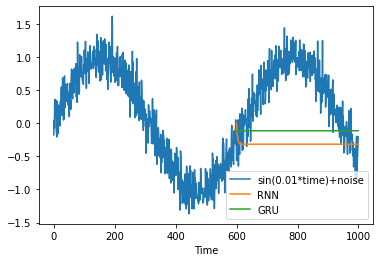

In [123]:
T = 1000
time = torch.arange(0.0, T)
X = torch.sin(0.01 * time) + 0.2 * torch.randn(T)
plt.plot(time.numpy(), X.numpy(), label="sin(0.01*time)+noise");
plt.plot(time[600:].numpy(), resultrnn, label='RNN')
plt.plot(time[600:].numpy(), resultgru, label='GRU')
plt.legend();
plt.xlabel("Time");
plt.show()